# Housing Price Prediction System - Interactive Demo

This notebook demonstrates the housing price prediction system that forecasts prices 5 years into the future.

## System Architecture

1. **SARIMA Model**: Forecasts market-level growth using Statistics Canada HPI
2. **Hedonic Pricing Model**: Models house-specific features using XGBoost
3. **Combined Prediction**: `future_price = current_price × market_growth × house_multiplier`

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from house_price_predictor import HousePricePredictor, HPIForecaster, HedonicPricingModel
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully")

: 

## Part 1: Load Pre-trained Models

We'll load the models that were already trained on the full datasets.

In [10]:
# Initialize predictor and load trained models
predictor = HousePricePredictor()

try:
    predictor.load_models('models/predictor.pkl')
    print("✅ Models loaded successfully!")
    print(f"\nMarket Growth Factor (5 years): {predictor.market_growth_factor:.4f}")
    print(f"Expected market appreciation: {(predictor.market_growth_factor-1)*100:.2f}%")
except FileNotFoundError:
    print("❌ Models not found. Training new models...")
    predictor.train()
    predictor.save_models('models/predictor.pkl')
    print("✅ Models trained and saved!")

Models loaded from models/predictor.pkl
✅ Models loaded successfully!

Market Growth Factor (5 years): 1.0512
Expected market appreciation: 5.12%


## Part 2: Explore the HPI Time Series

Let's visualize the historical Housing Price Index and the 5-year forecast.

HPI Time Series: 540 monthly observations
Period: 1981-01 to 2025-12

Current HPI: 122.00
Forecasted HPI (5 years): 128.25


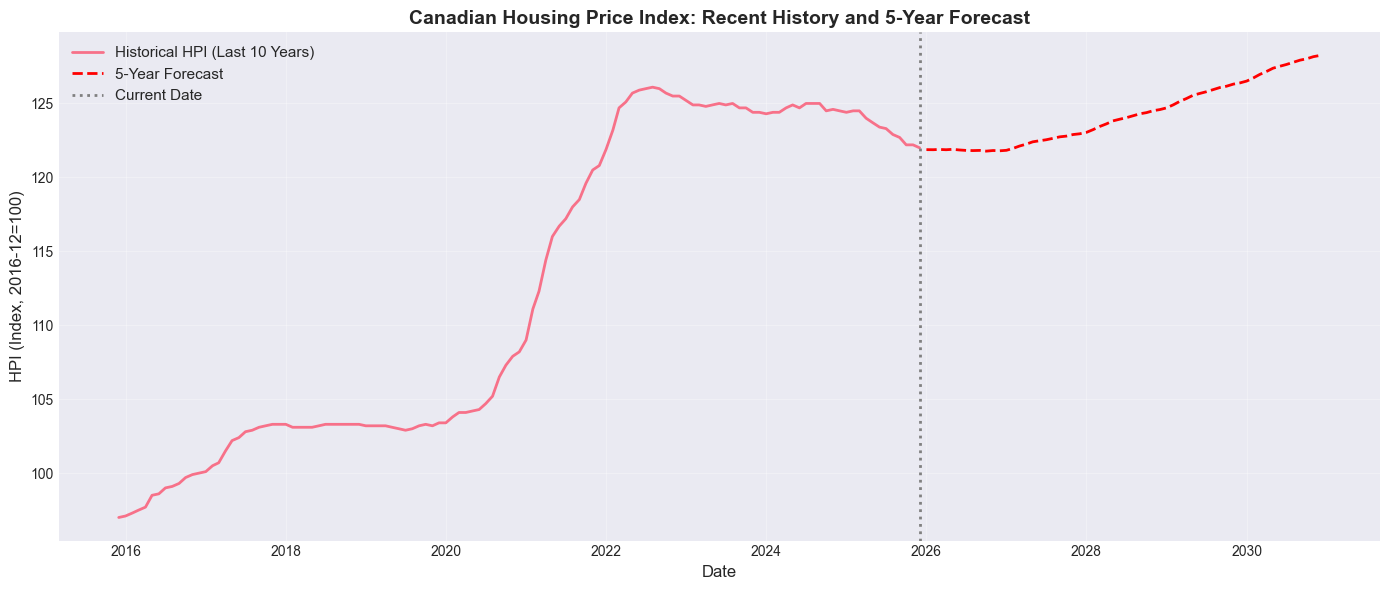

In [11]:
# Display HPI data
hpi_data = predictor.hpi_forecaster.hpi_data

print(f"HPI Time Series: {len(hpi_data)} monthly observations")
print(f"Period: {hpi_data.index[0].strftime('%Y-%m')} to {hpi_data.index[-1].strftime('%Y-%m')}")
print(f"\nCurrent HPI: {predictor.hpi_forecaster.current_hpi:.2f}")
print(f"Forecasted HPI (5 years): {predictor.hpi_forecaster.future_hpi:.2f}")

# Plot recent HPI history (last 10 years) and forecast
# Get last 10 years of data
ten_years_ago = hpi_data.index[-1] - pd.DateOffset(years=10)
recent_hpi = hpi_data[hpi_data.index >= ten_years_ago]

forecast = predictor.hpi_forecaster.model_fit.forecast(steps=60)
forecast_dates = pd.date_range(
    start=hpi_data.index[-1] + pd.DateOffset(months=1),
    periods=60,
    freq='MS'
)

plt.figure(figsize=(14, 6))
plt.plot(recent_hpi.index, recent_hpi.values, label='Historical HPI (Last 10 Years)', linewidth=2)
plt.plot(forecast_dates, forecast.values, label='5-Year Forecast', linewidth=2, linestyle='--', color='red')
plt.axvline(hpi_data.index[-1], color='gray', linestyle=':', label='Current Date', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('HPI (Index, 2016-12=100)', fontsize=12)
plt.title('Canadian Housing Price Index: Recent History and 5-Year Forecast', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Part 3: Explore the Housing Dataset

Let's examine the cross-sectional housing data used to train the hedonic pricing model.

Housing Dataset: 44896 listings

Price Statistics:
count        $44,896
mean      $1,070,457
std       $1,442,961
min          $50,000
25%         $399,990
50%         $688,000
75%       $1,200,000
max      $58,800,000
Name: Price, dtype: str


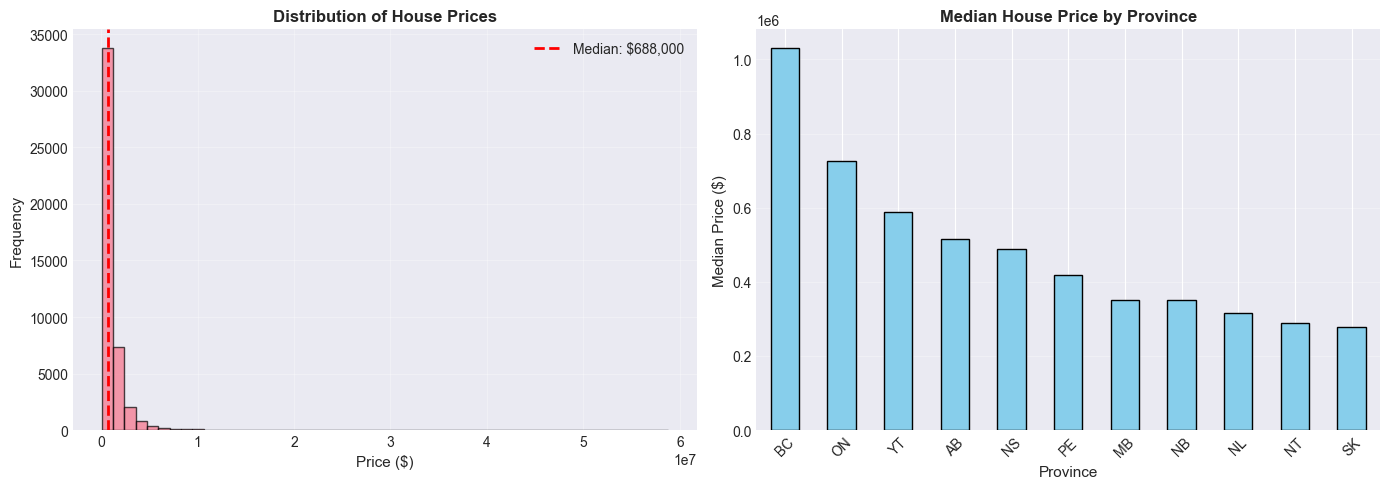

In [12]:
# Load housing data
df_housing = pd.read_csv('data/cleaned_canada.csv')

print(f"Housing Dataset: {len(df_housing)} listings")
print(f"\nPrice Statistics:")
print(df_housing['Price'].describe().apply(lambda x: f'${x:,.0f}'))

# Visualize price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of prices
axes[0].hist(df_housing['Price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of House Prices', fontsize=12, fontweight='bold')
axes[0].axvline(df_housing['Price'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${df_housing["Price"].median():,.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Price by province
price_by_province = df_housing.groupby('Province')['Price'].median().sort_values(ascending=False)
price_by_province.plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_xlabel('Province', fontsize=11)
axes[1].set_ylabel('Median Price ($)', fontsize=11)
axes[1].set_title('Median House Price by Province', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

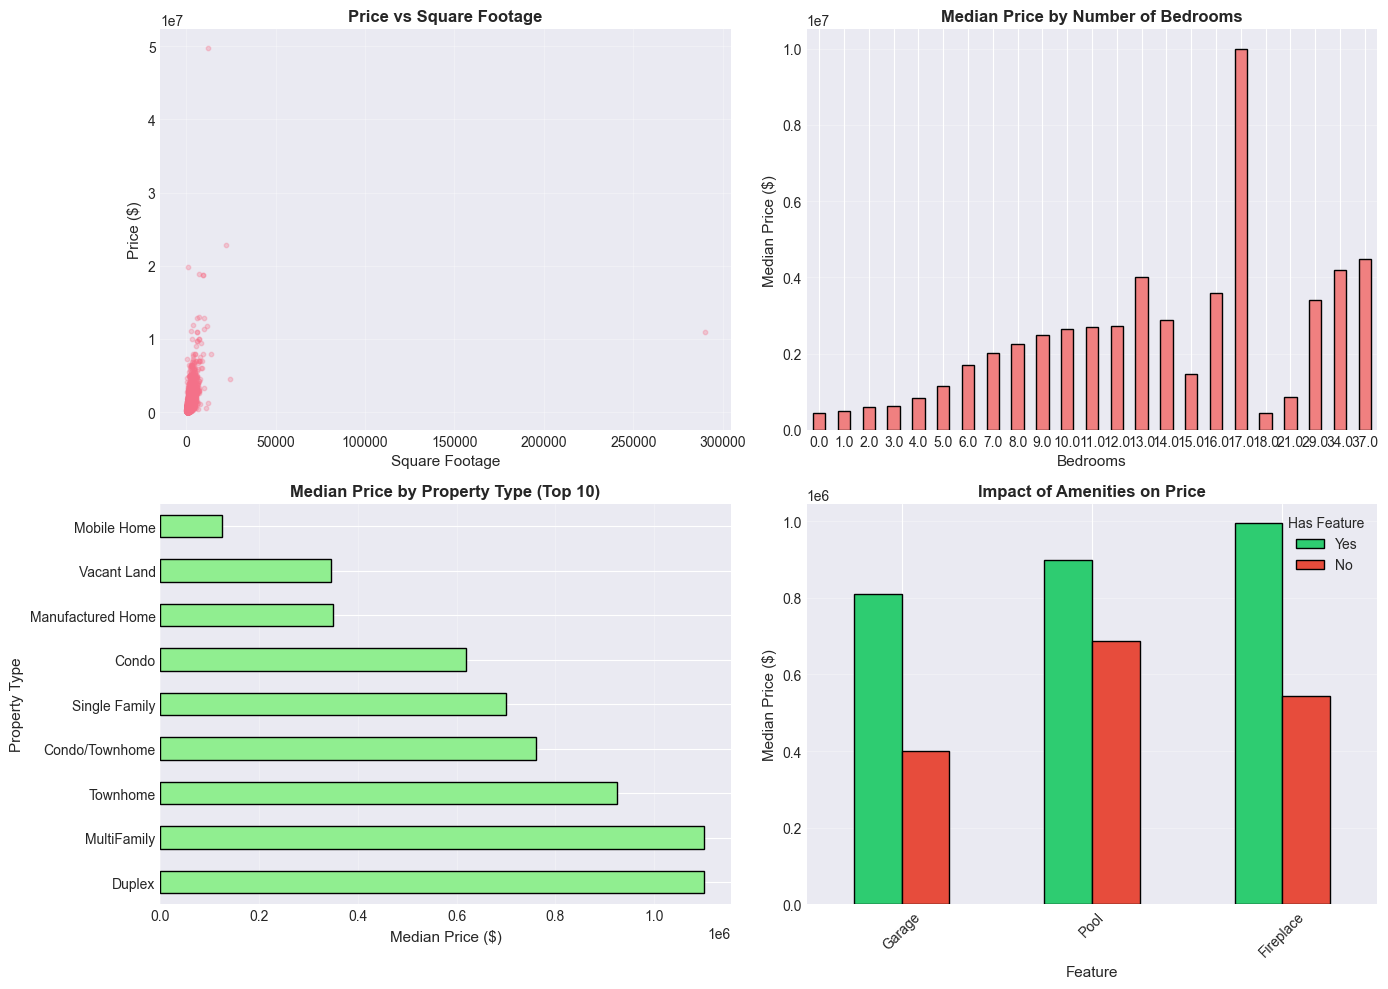

In [13]:
# Visualize relationships between features and price
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price vs Square Footage
sample_data = df_housing.sample(5000, random_state=42)  # Sample for performance
axes[0, 0].scatter(sample_data['Square Footage'], sample_data['Price'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Square Footage', fontsize=11)
axes[0, 0].set_ylabel('Price ($)', fontsize=11)
axes[0, 0].set_title('Price vs Square Footage', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Price vs Bedrooms
df_housing.groupby('Bedrooms')['Price'].median().plot(kind='bar', ax=axes[0, 1], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Bedrooms', fontsize=11)
axes[0, 1].set_ylabel('Median Price ($)', fontsize=11)
axes[0, 1].set_title('Median Price by Number of Bedrooms', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Price by Property Type
price_by_type = df_housing.groupby('Property Type')['Price'].median().sort_values(ascending=False).head(10)
price_by_type.plot(kind='barh', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Median Price ($)', fontsize=11)
axes[1, 0].set_ylabel('Property Type', fontsize=11)
axes[1, 0].set_title('Median Price by Property Type (Top 10)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Price with vs without specific features
feature_comparison = pd.DataFrame({
    'Garage': [df_housing[df_housing['Garage'] == 'Yes']['Price'].median(),
               df_housing[df_housing['Garage'] == 'No']['Price'].median()],
    'Pool': [df_housing[df_housing['Pool'] == 'Yes']['Price'].median(),
             df_housing[df_housing['Pool'] == 'No']['Price'].median()],
    'Fireplace': [df_housing[df_housing['Fireplace'] == 'Yes']['Price'].median(),
                  df_housing[df_housing['Fireplace'] == 'No']['Price'].median()],
}, index=['Yes', 'No'])

feature_comparison.T.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1, 1].set_xlabel('Feature', fontsize=11)
axes[1, 1].set_ylabel('Median Price ($)', fontsize=11)
axes[1, 1].set_title('Impact of Amenities on Price', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Has Feature')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 4: Make Custom Predictions

Now let's make predictions for different house scenarios.


5-YEAR PREDICTIONS FOR DIFFERENT SCENARIOS
                     Scenario  Current Price  Future Price   Dollar Gain  Appreciation %  Market Growth %  Feature Adj %
       Starter Home - Calgary         400000  2.865629e+05 -1.134371e+05      -28.359270         5.120462     -31.848919
      Family Home - Vancouver        1500000  1.050780e+06 -4.492202e+05      -29.948011         5.120462     -33.360271
      Luxury Estate - Kelowna        2500000  3.617925e+06  1.117925e+06       44.717013         5.120462      37.667786
Rural Property - Saskatchewan         350000  4.395358e+05  8.953582e+04       25.581664         5.120462      19.464529


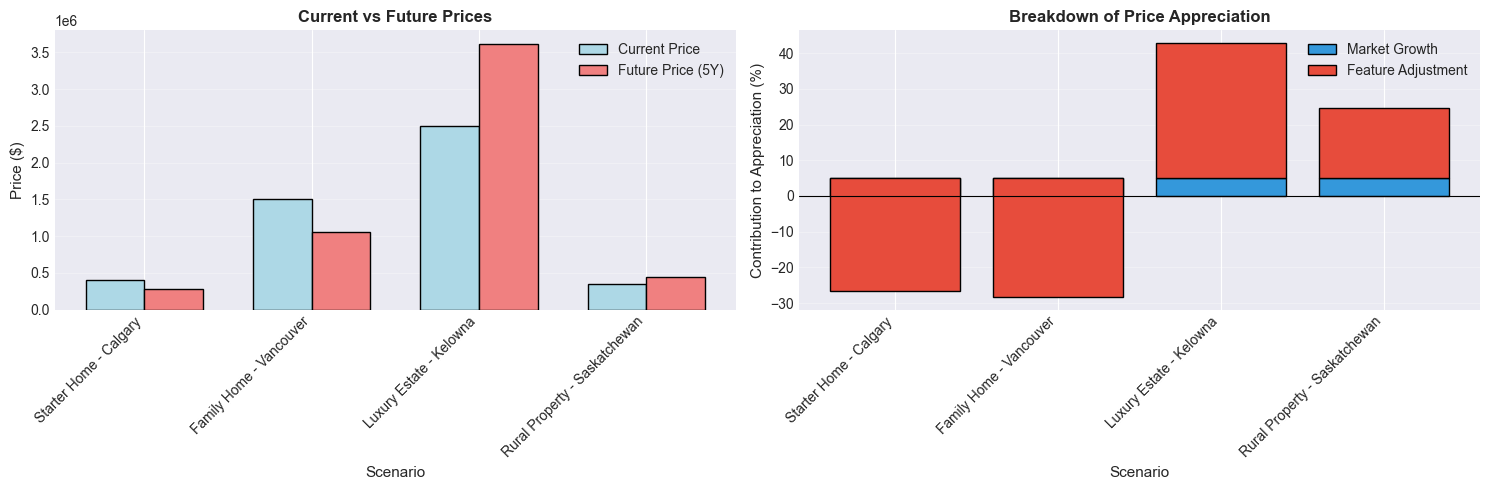

In [14]:
# Define house scenarios
scenarios = [
    {
        'name': 'Starter Home - Calgary',
        'current_price': 400000,
        'features': {
            'Province': 'AB',
            'Property Type': 'Condo',
            'Bedrooms': 2.0,
            'Bathrooms': 1.0,
            'Square Footage': 850.0,
            'Acreage': 0.0,
            'Garage': 'No',
            'Parking': 'Yes',
            'Basement': '',
            'Fireplace': 'No',
            'Heating': 'forced air',
            'Pool': 'No',
            'Waterfront': 'No'
        }
    },
    {
        'name': 'Family Home - Vancouver',
        'current_price': 1500000,
        'features': {
            'Province': 'BC',
            'Property Type': 'Single Family',
            'Bedrooms': 4.0,
            'Bathrooms': 3.0,
            'Square Footage': 2500.0,
            'Acreage': 0.15,
            'Garage': 'Yes',
            'Parking': 'Yes',
            'Basement': 'Finished',
            'Fireplace': 'Yes',
            'Heating': 'forced air',
            'Pool': 'No',
            'Waterfront': 'No'
        }
    },
    {
        'name': 'Luxury Estate - Kelowna',
        'current_price': 2500000,
        'features': {
            'Province': 'BC',
            'Property Type': 'Single Family',
            'Bedrooms': 6.0,
            'Bathrooms': 5.0,
            'Square Footage': 5000.0,
            'Acreage': 1.0,
            'Garage': 'Yes',
            'Parking': 'Yes',
            'Basement': 'Finished',
            'Fireplace': 'Yes',
            'Heating': 'forced air',
            'Pool': 'Yes',
            'Waterfront': 'Yes'
        }
    },
    {
        'name': 'Rural Property - Saskatchewan',
        'current_price': 350000,
        'features': {
            'Province': 'SK',
            'Property Type': 'Single Family',
            'Bedrooms': 3.0,
            'Bathrooms': 2.0,
            'Square Footage': 1400.0,
            'Acreage': 5.0,
            'Garage': 'Yes',
            'Parking': 'Yes',
            'Basement': 'Finished',
            'Fireplace': 'Yes',
            'Heating': 'forced air',
            'Pool': 'No',
            'Waterfront': 'No'
        }
    }
]

# Make predictions for all scenarios
results = []
for scenario in scenarios:
    yearly_predictions, breakdown = predictor.predict_future_price(
        scenario['current_price'],
        scenario['features']
    )
    results.append({
        'Scenario': scenario['name'],
        'Current Price': scenario['current_price'],
        'Future Price': yearly_predictions[5],  # 5-year price
        'Dollar Gain': yearly_predictions[5] - scenario['current_price'],
        'Appreciation %': breakdown['total_appreciation'],
        'Market Growth %': breakdown['market_appreciation'],
        'Feature Adj %': breakdown['feature_adjustment']
    })

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*100)
print("5-YEAR PREDICTIONS FOR DIFFERENT SCENARIOS")
print("="*100)
print(results_df.to_string(index=False))

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Price comparison
x_pos = np.arange(len(results_df))
width = 0.35
axes[0].bar(x_pos - width/2, results_df['Current Price'], width, label='Current Price', color='lightblue', edgecolor='black')
axes[0].bar(x_pos + width/2, results_df['Future Price'], width, label='Future Price (5Y)', color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Scenario', fontsize=11)
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].set_title('Current vs Future Prices', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([s['name'] for s in scenarios], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Appreciation breakdown
market_contrib = results_df['Market Growth %']
feature_contrib = results_df['Feature Adj %']
axes[1].bar(x_pos, market_contrib, label='Market Growth', color='#3498db', edgecolor='black')
axes[1].bar(x_pos, feature_contrib, bottom=market_contrib, label='Feature Adjustment', color='#e74c3c', edgecolor='black')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_xlabel('Scenario', fontsize=11)
axes[1].set_ylabel('Contribution to Appreciation (%)', fontsize=11)
axes[1].set_title('Breakdown of Price Appreciation', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([s['name'] for s in scenarios], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 5: Interactive Prediction Tool

Create your own house and see the prediction!


5-YEAR PRICE PREDICTION

Current Price:              $800,000
Expected Current Price:     $816,810

--- Growth Components ---
Market Growth Factor:       1.0512 (+5.12%)
House Feature Adjustment:   1.0210 (+2.10%)

--- Final Prediction ---
Predicted Future Price:     $858,635
Total Appreciation:         +7.33%
Dollar Gain:                $58,635


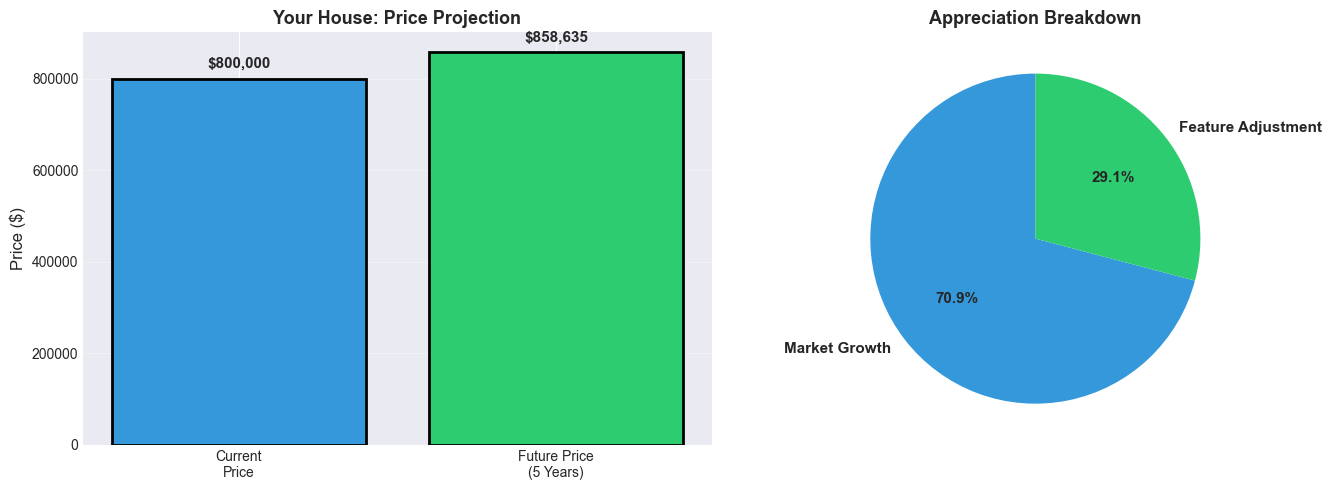


💡 Interpretation:
   Your house appears undervalued relative to its features (+2.10%)
   Expected to appreciate faster than the market average.


In [ ]:
# Define your custom house
custom_house = {
    'current_price': 800000,  # Change this to your house price
    'features': {
        'Province': 'BC',  # AB, BC, SK, ON, etc.
        'Property Type': 'Single Family',  # Single Family, Condo, Townhome, etc.
        'Bedrooms': 3.0,
        'Bathrooms': 2.5,
        'Square Footage': 2200.0,
        'Acreage': 0.2,
        'Garage': 'Yes',  # Yes or No
        'Parking': 'Yes',  # Yes or No
        'Basement': 'Finished',  # Finished, Partial, No basement, or ''
        'Fireplace': 'Yes',  # Yes or No
        'Heating': 'forced air',  # forced air, heat pump, radiant, etc.
        'Pool': 'No',  # Yes or No
        'Waterfront': 'No'  # Yes or No
    }
}

# Make prediction
yearly_predictions, breakdown = predictor.predict_future_price(
    custom_house['current_price'],
    custom_house['features']
)

# Display detailed results
predictor.print_prediction(breakdown)

# Visualize your prediction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price change visualization
prices = [custom_house['current_price'], yearly_predictions[5]]
labels = ['Current\nPrice', 'Future Price\n(5 Years)']
colors = ['#3498db', '#2ecc71' if yearly_predictions[5] > custom_house['current_price'] else '#e74c3c']
axes[0].bar(labels, prices, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title('Your House: Price Projection', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (label, price) in enumerate(zip(labels, prices)):
    axes[0].text(i, price + max(prices)*0.02, f'${price:,.0f}', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Appreciation breakdown pie chart
components = {
    'Market Growth': breakdown['market_appreciation'],
    'Feature Adjustment': breakdown['feature_adjustment']
}
colors_pie = ['#3498db', '#e74c3c' if breakdown['feature_adjustment'] < 0 else '#2ecc71']
axes[1].pie(list(components.values()), labels=list(components.keys()), 
           autopct='%1.1f%%', colors=colors_pie, startangle=90,
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Appreciation Breakdown', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
if breakdown['house_multiplier'] > 1.0:
    print(f"   Your house appears undervalued relative to its features (+{breakdown['feature_adjustment']:.2f}%)")
    print(f"   Expected to appreciate faster than the market average.")
elif breakdown['house_multiplier'] < 1.0:
    print(f"   Your house appears overvalued relative to its features ({breakdown['feature_adjustment']:.2f}%)")
    print(f"   Expected to appreciate slower than the market average.")
else:
    print(f"   Your house is fairly valued relative to its features.")
    print(f"   Expected to appreciate at the market rate.")

## Part 6: Model Feature Importance

Let's see which features matter most for house pricing.

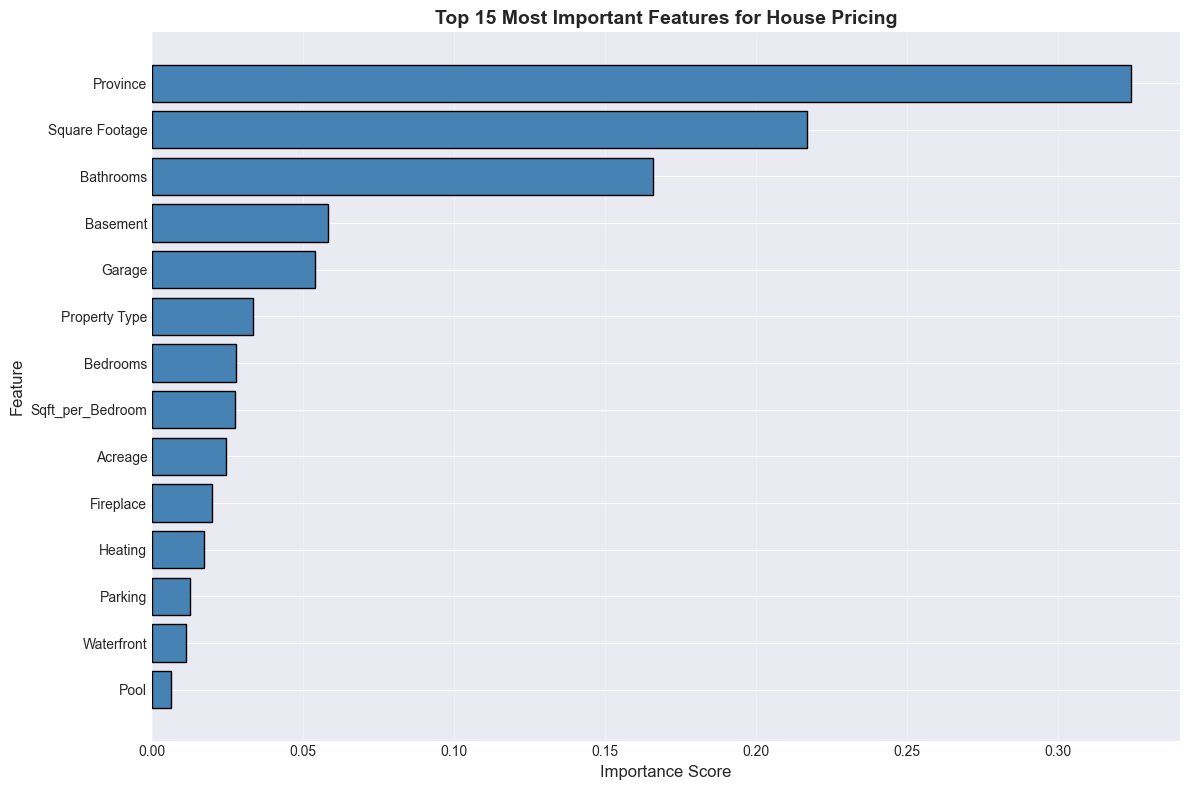


Top 10 Most Important Features:
         Feature  Importance
        Province    0.324340
  Square Footage    0.217069
       Bathrooms    0.166028
        Basement    0.058400
          Garage    0.053965
   Property Type    0.033393
        Bedrooms    0.027832
Sqft_per_Bedroom    0.027477
         Acreage    0.024593
       Fireplace    0.019736


In [12]:
# Get feature importance from the hedonic model
feature_importance = pd.DataFrame({
    'Feature': predictor.hedonic_model.feature_columns,
    'Importance': predictor.hedonic_model.model.feature_importances_
}).sort_values('Importance', ascending=False)

# Clean up feature names
feature_importance['Feature'] = feature_importance['Feature'].str.replace('_encoded', '')

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features for House Pricing', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## Summary

This notebook demonstrated:

1. ✅ **Market-level forecasting** using SARIMA on HPI data
2. ✅ **House-level pricing** using hedonic XGBoost model
3. ✅ **Combined predictions** that separate market growth from feature effects
4. ✅ **Interactive tools** for custom house predictions
5. ✅ **Feature analysis** showing what drives house prices

### Key Findings:
- **Market Growth (5Y)**: +5.12% based on SARIMA forecast
- **Most Important Features**: Province, Square Footage, Bathrooms
- **Model Performance**: R² = 0.79 on test set

### Statistical Validity:
This approach correctly separates:
- **Time-variant effects** (market trends) → SARIMA on HPI
- **Time-invariant effects** (house features) → Hedonic model

This avoids the common mistake of treating cross-sectional data as time series.